In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['font.family'] = 'monospace'
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import xgboost as xgb

# Setup paths
W=os.path.abspath(os.path.join(os.getcwd()))
D=os.path.join(W,'productos/test/precipitation-forecast-co/data')
M=os.path.join(W,'productos/test/precipitation-forecast-co/models')
df=pd.read_parquet(os.path.join(D,'processing/processing_month.parquet'))

# Keep row with longest normalized array per station
df['l']=df['ValoresNormalizados'].apply(lambda x:len(x) if x is not None else 0)
df=df.loc[df.groupby('CodigoEstacion')['l'].idxmax()].drop(columns=['l']).reset_index(drop=True)

# Expand IMFs and VMDs
imf_n=df['IMFs'].str.len().max()
imf_c=[f'imf{i+1}' for i in range(imf_n)]
vmd_n=df['VMDs'].str.len().max()
vmd_c=[f'vmd{i+1}' for i in range(vmd_n)]
df=pd.concat([df,pd.DataFrame(df['IMFs'].tolist(),columns=imf_c),pd.DataFrame(df['VMDs'].tolist(),columns=vmd_c)],axis=1)
df.drop(columns=['IMFs','VMDs'],inplace=True)
fts=['ValoresNormalizados']+imf_c+vmd_c

# Sliding window dataset
def winset(df,n,fts):
    res=[]
    for _,r in df.iterrows():
        v=r['ValoresNormalizados'];d=r['FechaInicio']
        if v is None or len(v)<=n:continue
        for i in range(len(v)-n-1):
            row={'CodigoEstacion':r['CodigoEstacion'],'ValorMaximo':r['ValorMaximo']}
            row['FechaInicio']=d+pd.DateOffset(months=i)
            row['FechaFin']=d+pd.DateOffset(months=i+n-1)
            row['FechaPrediccion']=d+pd.DateOffset(months=i+n)
            for f in fts:
                x=r[f] if f in df.columns else None
                row[f]=x[i:i+n] if x is not None and len(x)>i+n-1 else None
            row['Prediccion']=v[i+n] if i+n<len(v) else None
            res.append(row)
    return pd.DataFrame(res)

df=winset(df,32,fts)

# Attach climatology
clima=pd.read_excel(os.path.join(D,'climatologia.xlsx'),sheet_name='PRECIPITACIÓN',header=1,dtype={'CODIGO':str})
mm={'JAN':'ENE','FEB':'FEB','MAR':'MAR','APR':'ABR','MAY':'MAY','JUN':'JUN','JUL':'JUL','AUG':'AGO',
    'SEP':'SEP','OCT':'OCT','NOV':'NOV','DEC':'DIC'}
df['MesPrediccion']=pd.to_datetime(df['FechaPrediccion']).dt.strftime('%b').str.upper().replace(mm)
def gcl(r):
    rc=clima[clima['CODIGO']==r['CodigoEstacion']]
    return rc.iloc[0][r['MesPrediccion']] if not rc.empty and r['MesPrediccion'] in rc.columns else np.nan
df['Climatologia']=df.apply(gcl,axis=1)
df.dropna(subset=['Climatologia'],inplace=True)
df.reset_index(drop=True,inplace=True)

# Train/val split by station, preserve order
trn=pd.DataFrame();val=pd.DataFrame()
for _,g in df.groupby('CodigoEstacion'):
    s=int(len(g)*0.8)
    trn=pd.concat([trn,g.iloc[:s]],ignore_index=True)
    val=pd.concat([val,g.iloc[s:]],ignore_index=True)
print(f"Train size:{len(trn)} Val size:{len(val)}")

Train size:149874 Val size:38180


## XGBoost

Eval n=38180
XGBoost Model - Metrics:
RMSE:103.608 MAE:70.041 Bias:3.231 FB:0.016 NSE:0.651 FA:67.725 OA:110.874 AC:0.410


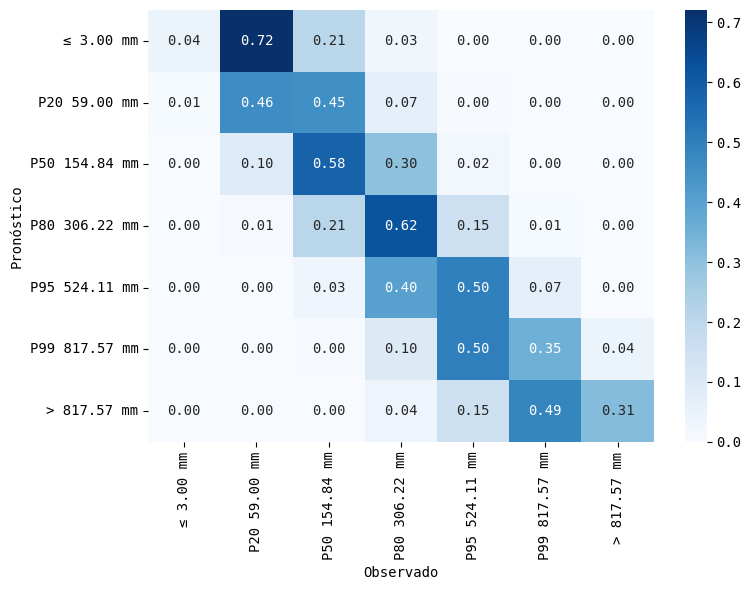

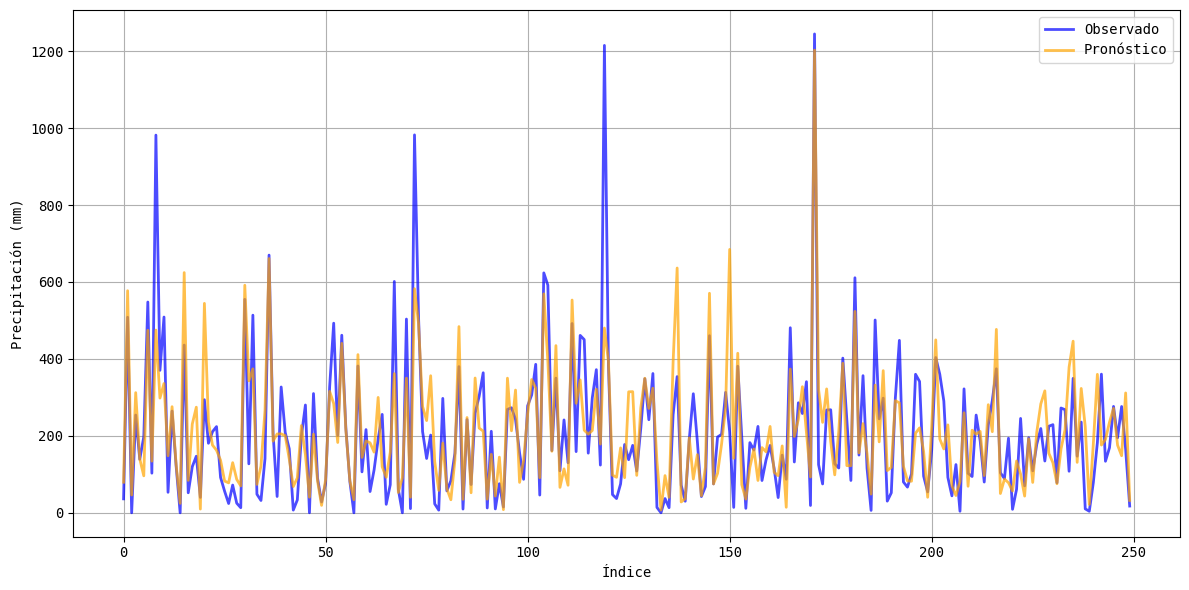

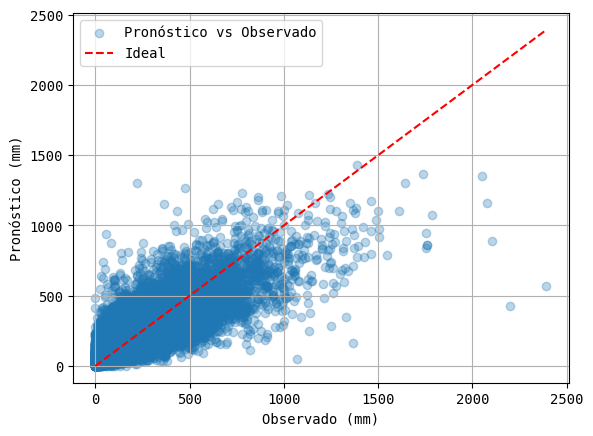

In [ ]:
ftr = 'ValoresNormalizados'
cl = 32
pred = pd.DataFrame()
model_path = os.path.join(M, f"xgb_{ftr}.json")
model = xgb.Booster()
model.load_model(model_path)

dat = val[ftr].values
out = np.zeros(len(dat))
idxs = [i for i, x in enumerate(dat) if x is not None and not np.all(np.array(x) == 0)]

X = np.array([np.array(dat[i][-cl:]) for i in idxs]) if idxs else None
if X is not None and len(X):
    dX = xgb.DMatrix(X)
    y = model.predict(dX)
    for k, j in enumerate(idxs):
        out[j] = y[k]

pred[ftr] = out

o = val['Prediccion'].values * val['ValorMaximo'].values
f = pred.sum(axis=1).values * val['ValorMaximo'].values
f[f < 0] = 0
c = val['Climatologia'].values
m = (~np.isnan(o)) & (~np.isnan(f)) & (~np.isnan(c))
o, f, c = o[m], f[m], c[m]

print(f"Eval n={len(o)}")
rmse = np.sqrt(np.mean((f - o) ** 2))
bias = np.mean(f - o)
fa = f - c
fam = np.mean(fa)
fa2 = np.sqrt(np.mean((fa - fam) ** 2))
oa = o - c
oam = np.mean(oa)
oa2 = np.sqrt(np.mean((oa - oam) ** 2))
num = np.mean((fa - fam) * (oa - oam))
den = np.sqrt(np.mean((fa - fam) ** 2)) * np.sqrt(np.mean((oa - oam) ** 2))
ac = num / den if den != 0 else np.nan
mae = np.mean(np.abs(f - o))
nden = np.sum((o - np.mean(o)) ** 2)
nse = 1 - (np.sum((f - o) ** 2) / nden) if nden != 0 else np.nan
fb = 2 * (np.mean(f) - np.mean(o)) / (np.mean(f) + np.mean(o)) if (np.mean(f) + np.mean(o)) != 0 else np.nan

print("XGBoost Model - Metrics:")
print(f"RMSE:{rmse:.3f} MAE:{mae:.3f} Bias:{bias:.3f} FB:{fb:.3f} NSE:{nse:.3f} FA:{fa2:.3f} OA:{oa2:.3f} AC:{ac:.3f}")

# === Confusion matrix ===
df_eval = pd.DataFrame({'o': o, 'f': f})
ps = df_eval['o'].quantile([0.2, 0.5, 0.8, 0.95, 0.99])
bins = [-np.inf, 3] + list(ps.values) + [np.inf]
q = ["", "P20", "P50", "P80", "P95", "P99", ""]
lbls = []

for i in range(len(bins) - 1):
    a, b = bins[i], bins[i + 1]
    if np.isneginf(a):
        t = f"≤ {b:.2f} mm"
    elif np.isposinf(b):
        t = f"> {a:.2f} mm"
    else:
        t = f"{q[i]} {b:.2f} mm"
    lbls.append(t)

df_eval['o_cat'] = pd.cut(df_eval['o'], bins=bins, labels=lbls)
df_eval['f_cat'] = pd.cut(df_eval['f'], bins=bins, labels=lbls)
cm = confusion_matrix(df_eval['o_cat'], df_eval['f_cat'], labels=lbls, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=lbls, yticklabels=lbls)
plt.xlabel("Observado")
plt.ylabel("Pronóstico")
plt.tight_layout()
plt.show()

# Forecast vs observed
if len(o) > 250:
    idxs = np.random.choice(len(o), size=250, replace=False)
else:
    idxs = np.arange(len(o))
plt.figure(figsize=(12, 6))
plt.plot(o[idxs], label='Observado', color='blue', lw=2, alpha=0.7)
plt.plot(f[idxs], label='Pronóstico', color='orange', lw=2, alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Precipitación (mm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot
plt.scatter(o, f, alpha=0.3, label='Pronóstico vs Observado')
plt.plot([o.min(), o.max()], [o.min(), o.max()], 'r--', label='Ideal')
plt.xlabel('Observado (mm)')
plt.ylabel('Pronóstico (mm)')
plt.legend()
plt.grid(True)
plt.show()

## Conv LSTM - biLSTM

1194/1194 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Eval n=38180
Model mlstm_ValoresNormalizados - Metrics:
RMSE:107.665 MAE:73.222 Bias:2.161 FB:0.011 NSE:0.623 FA:68.659 OA:110.874 AC:0.356


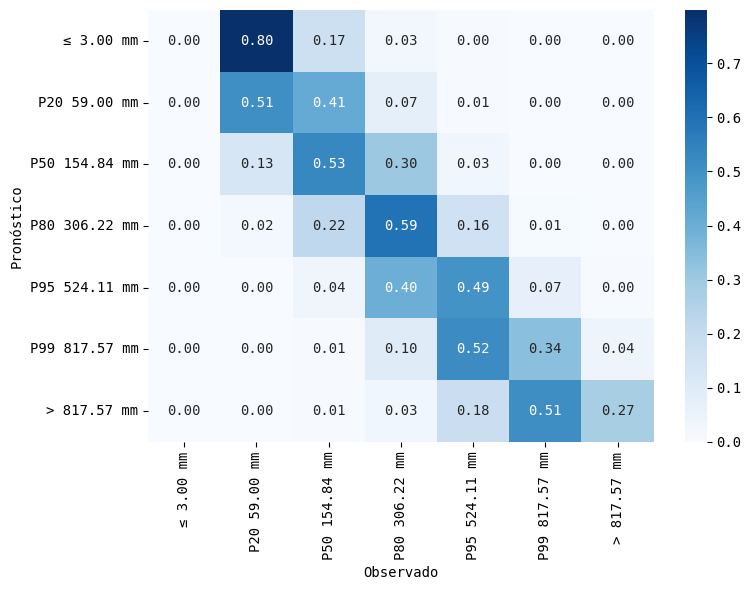

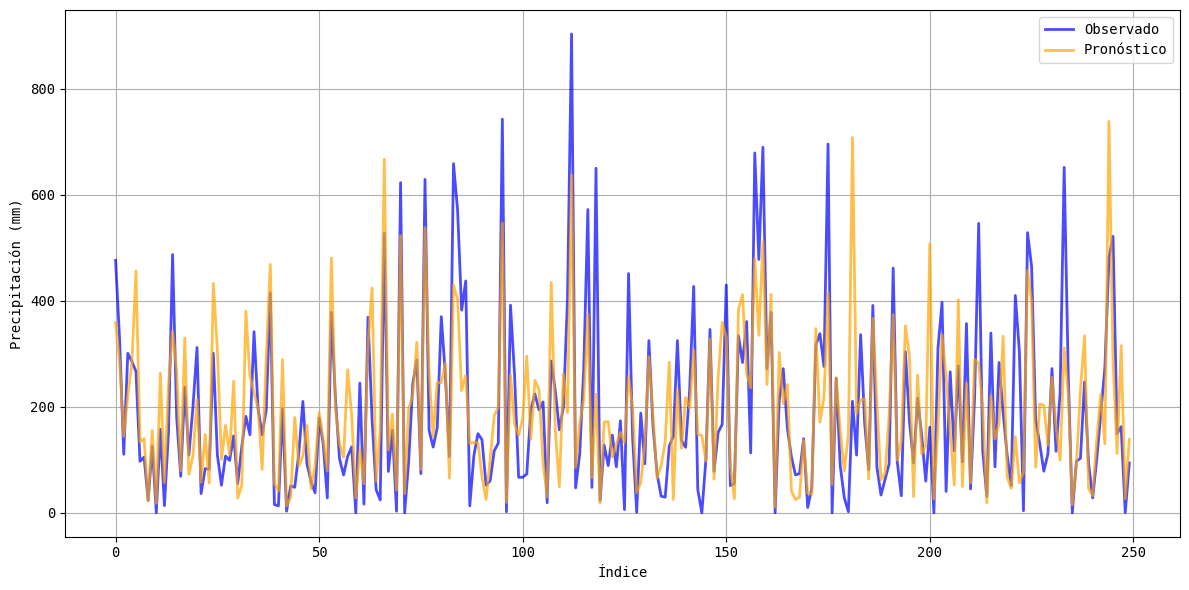

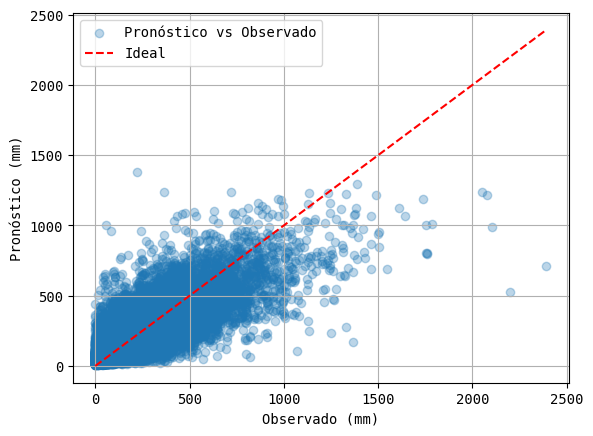

1194/1194 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step
Eval n=38180
Model mbilstm_ValoresNormalizados - Metrics:
RMSE:107.453 MAE:73.366 Bias:2.884 FB:0.015 NSE:0.625 FA:68.194 OA:110.874 AC:0.357


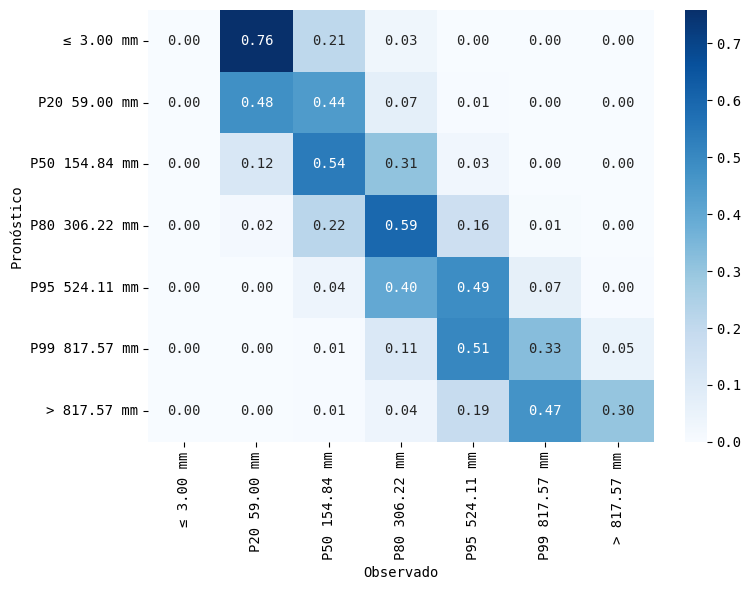

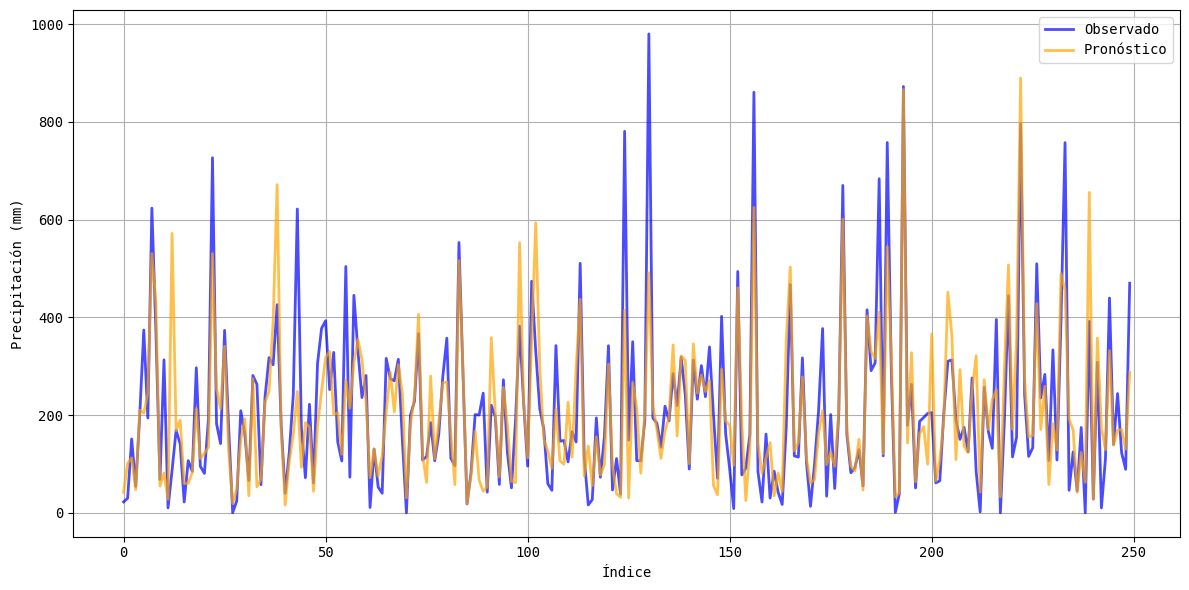

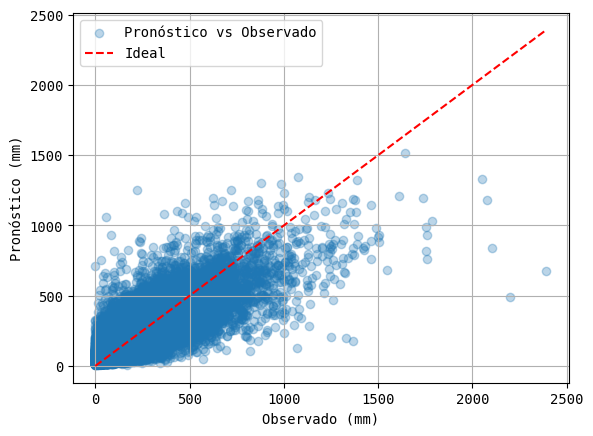

1194/1194 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Eval n=38180
Model msbilstm_ValoresNormalizados - Metrics:
RMSE:107.830 MAE:73.558 Bias:0.863 FB:0.004 NSE:0.622 FA:66.431 OA:110.874 AC:0.345


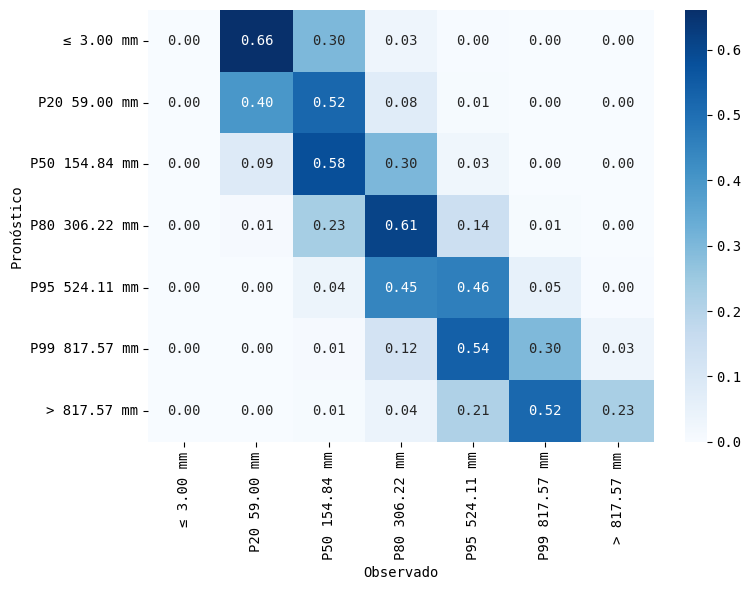

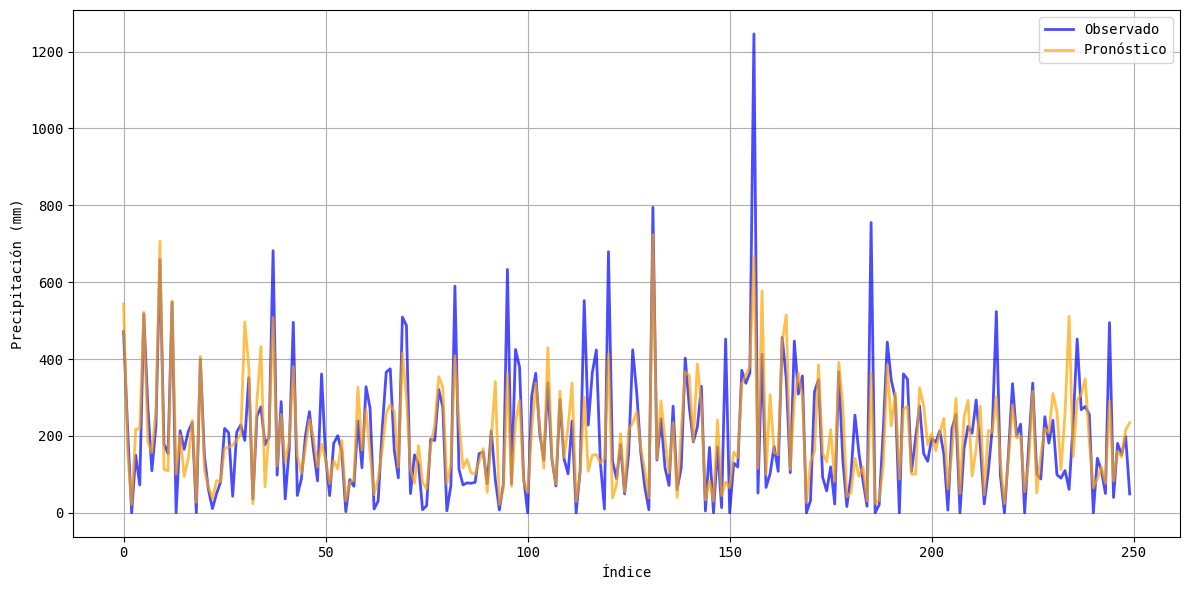

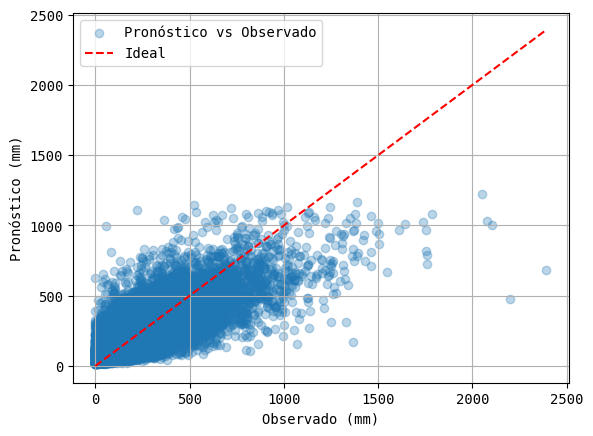

In [ ]:
# Predict
ftr='ValoresNormalizados'
models = [f'mlstm_{ftr}', 
          f'mbilstm_{ftr}', 
          f'msbilstm_{ftr}'
          ]

cl=32;pred=pd.DataFrame()
for model in models:
    mdl=load_model(os.path.join(M,f"{model}.keras"), compile=False)
    dat=val[ftr].values
    out=np.zeros(len(dat))
    idxs=[i for i,x in enumerate(dat) if x is not None and not np.all(np.array(x)==0)]
    X=np.array([np.array(dat[i]) for i in idxs]).reshape(-1,cl,1) if idxs else None
    if idxs and len(X):
        y=mdl.predict(X,verbose=1).flatten()
        for k,j in enumerate(idxs): out[j]=y[k]
    pred[ftr]=out

    # Metrics
    o=val['Prediccion'].values*val['ValorMaximo'].values
    f=pred.sum(axis=1).values*val['ValorMaximo'].values
    f[f<0]=0
    c=val['Climatologia'].values
    m=(~np.isnan(o))&(~np.isnan(f))&(~np.isnan(c))
    o,f,c=o[m],f[m],c[m]
    print(f"Eval n={len(o)}")
    rmse=np.sqrt(np.mean((f-o)**2))
    bias=np.mean(f-o)
    fa=f-c;fam=np.mean(fa)
    fa2=np.sqrt(np.mean((fa-fam)**2))
    oa=o-c;oam=np.mean(oa)
    oa2=np.sqrt(np.mean((oa-oam)**2))
    num=np.mean((fa-fam)*(oa-oam))
    den=np.sqrt(np.mean((fa-fam)**2))*np.sqrt(np.mean((oa-oam)**2))
    ac=num/den if den!=0 else np.nan
    mae=np.mean(np.abs(f-o))
    nden=np.sum((o-np.mean(o))**2)
    nse=1-(np.sum((f-o)**2)/nden) if nden!=0 else np.nan
    fb=2*(np.mean(f)-np.mean(o))/(np.mean(f)+np.mean(o)) if (np.mean(f)+np.mean(o))!=0 else np.nan
    print(f"Model {model} - Metrics:")
    print(f"RMSE:{rmse:.3f} MAE:{mae:.3f} Bias:{bias:.3f} FB:{fb:.3f} NSE:{nse:.3f} FA:{fa2:.3f} OA:{oa2:.3f} AC:{ac:.3f}")

    # Evaluation DataFrame and confusion matrix
    df_eval = pd.DataFrame({'o': o, 'f': f})
    ps = df_eval['o'].quantile([0.2, 0.5, 0.8, 0.95, 0.99])
    bins = [-np.inf, 3] + list(ps.values) + [np.inf]
    q = ["", "P20", "P50", "P80", "P95", "P99", ""]

    lbls = []
    for i in range(len(bins) - 1):
        a, b = bins[i], bins[i+1]
        if np.isneginf(a):
            t = f"≤ {b:.2f} mm"
        elif np.isposinf(b):
            t = f"> {a:.2f} mm"
        else:
            t = f"{q[i]} {b:.2f} mm"
        lbls.append(t)

    df_eval['o_cat'] = pd.cut(df_eval['o'], bins=bins, labels=lbls)
    df_eval['f_cat'] = pd.cut(df_eval['f'], bins=bins, labels=lbls)
    cm = confusion_matrix(df_eval['o_cat'], df_eval['f_cat'], labels=lbls, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=lbls, yticklabels=lbls)
    plt.xlabel("Observado")
    plt.ylabel("Pronóstico")
    plt.tight_layout()
    plt.show()

    # Forecast vs observed (samples)
    if len(o) > 250:
        idxs = np.random.choice(len(o), size=250, replace=False)
    else:
        idxs = np.arange(len(o))
    plt.figure(figsize=(12, 6))
    plt.plot(o[idxs], label='Observado', color='blue', lw=2, alpha=0.7)
    plt.plot(f[idxs], label='Pronóstico', color='orange', lw=2, alpha=0.7)
    plt.xlabel('Índice')
    plt.ylabel('Precipitación (mm)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Scatter plot
    plt.scatter(o, f, alpha=0.3, label='Pronóstico vs Observado')
    plt.plot([o.min(), o.max()], [o.min(), o.max()], 'r--', label='Ideal')
    plt.xlabel('Observado (mm)')
    plt.ylabel('Pronóstico (mm)')
    plt.legend()
    plt.grid(True)
    plt.show()

## CEEMDAN-VMD--BiLSTM

In [ ]:
# Setup paths
W=os.path.abspath(os.path.join(os.getcwd()))
D=os.path.join(W,'productos/test/precipitation-forecast-co/data')
M=os.path.join(W,'productos/test/precipitation-forecast-co/models')
df=pd.read_parquet(os.path.join(D,'processing/processing_month_128.parquet'))

# Expand IMFs and VMDs
imf_n=df['IMFs'].str.len().max()
imf_c=[f'imf{i+1}' for i in range(imf_n)]
vmd_n=df['VMDs'].str.len().max()
vmd_c=[f'vmd{i+1}' for i in range(vmd_n)]
df=pd.concat([df,pd.DataFrame(df['IMFs'].tolist(),columns=imf_c),pd.DataFrame(df['VMDs'].tolist(),columns=vmd_c)],axis=1)
df.drop(columns=['IMFs','VMDs'],inplace=True)
fts=['ValoresNormalizados']+imf_c+vmd_c

# Attach climatology
clima=pd.read_excel(os.path.join(D,'climatologia.xlsx'),sheet_name='PRECIPITACIÓN',header=1,dtype={'CODIGO':str})
mm={'JAN':'ENE','FEB':'FEB','MAR':'MAR','APR':'ABR','MAY':'MAY','JUN':'JUN','JUL':'JUL','AUG':'AGO',
    'SEP':'SEP','OCT':'OCT','NOV':'NOV','DEC':'DIC'}
df['MesPrediccion'] = (pd.to_datetime(df['FechaFin']) + pd.DateOffset(months=1)).dt.strftime('%b').str.upper().replace(mm)
def gcl(r):
    rc=clima[clima['CODIGO']==r['CodigoEstacion']]
    return rc.iloc[0][r['MesPrediccion']] if not rc.empty and r['MesPrediccion'] in rc.columns else np.nan
df['Climatologia']=df.apply(gcl,axis=1)
df.dropna(subset=['Climatologia'],inplace=True)
df.reset_index(drop=True,inplace=True)

# Train/val split by station, preserve order
trn=pd.DataFrame();val=pd.DataFrame()
for _,g in df.groupby('CodigoEstacion'):
    s=int(len(g)*0.8)
    trn=pd.concat([trn,g.iloc[:s]],ignore_index=True)
    val=pd.concat([val,g.iloc[s:]],ignore_index=True)
print(f"Train size:{len(trn)} Val size:{len(val)}")

Train size:61053 Val size:15779


In [45]:
cl=32
fts = imf_c + vmd_c
fts = [f for f in fts if f != 'imf1']
pred=pd.DataFrame()
for f in fts:
    mdl=load_model(os.path.join(M,f"mbilstm_{f}.keras"))
    dat=val[f].values
    out=np.zeros(len(dat))
    idxs=[i for i,x in enumerate(dat) if x is not None and not np.all(np.array(x)==0)]
    X = np.array([np.array(x)[-cl:] for i, x in enumerate(dat) if i in idxs]).reshape(-1, cl, 1) if idxs else None
    if idxs and len(X):
        y=mdl.predict(X,verbose=1).flatten()
        for k,j in enumerate(idxs): out[j]=y[k]
    pred[f]=out

494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


Eval n=15779
Model mbilstm2_ValoresNormalizados - Metrics:
RMSE:153.401 MAE:109.265 Bias:1.246 FB:0.006 NSE:0.261 FA:130.336 OA:113.089 AC:0.212


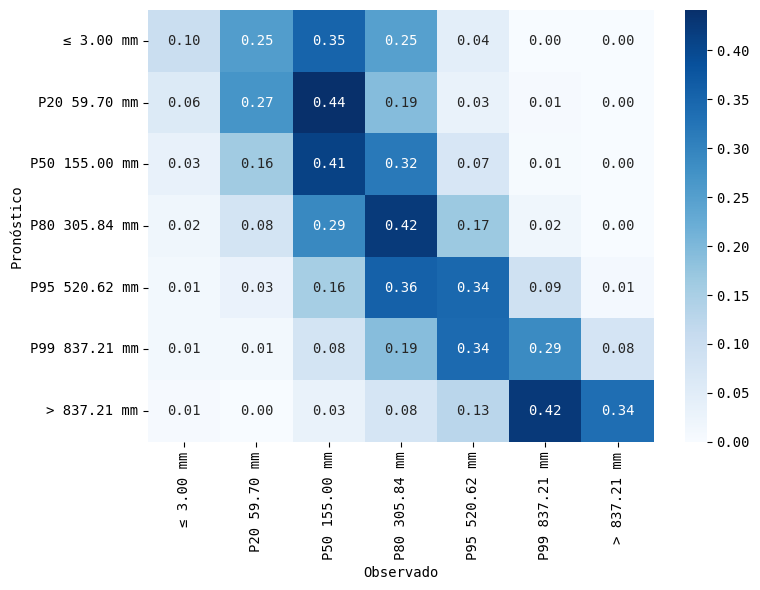

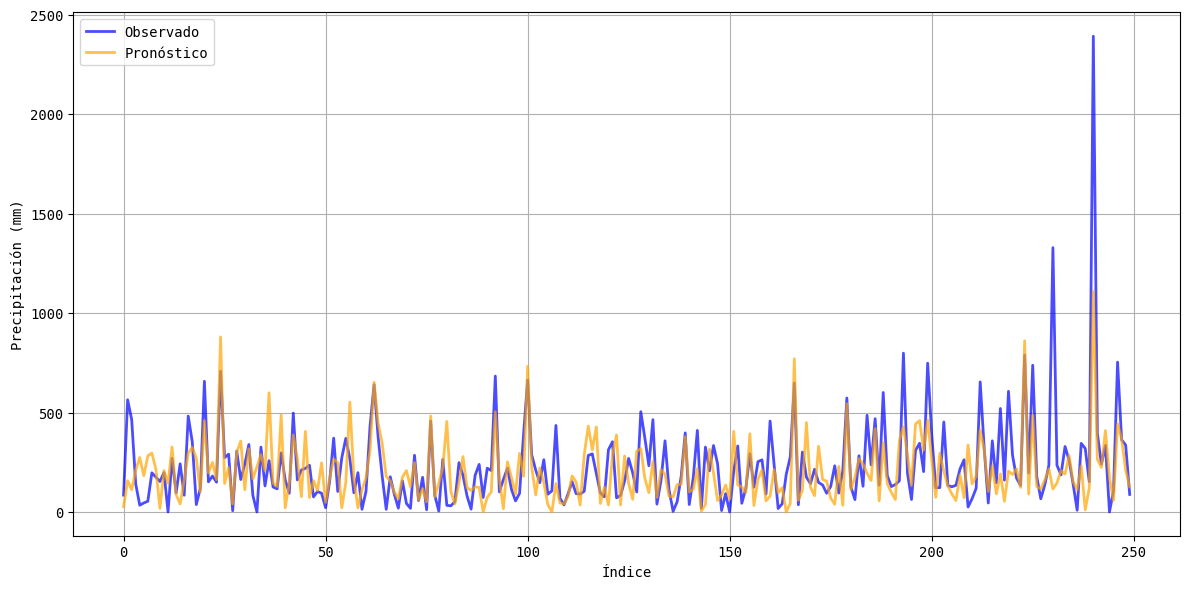

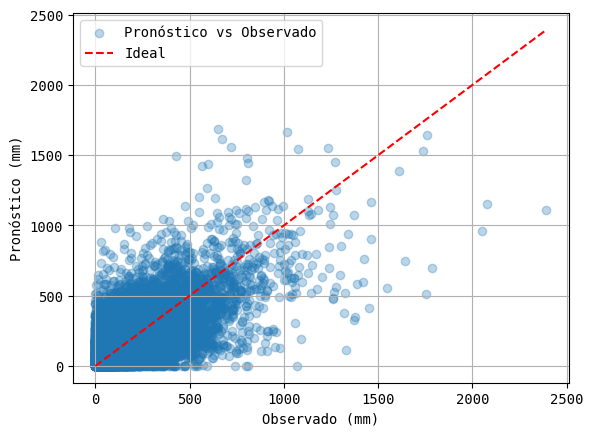

In [46]:
# Metrics
o=val['ValorPrediccion'].values*val['ValorMaximo'].values
f=pred.sum(axis=1).values*val['ValorMaximo'].values
f[f<0]=0
c=val['Climatologia'].values
m=(~np.isnan(o))&(~np.isnan(f))&(~np.isnan(c))
o,f,c=o[m],f[m],c[m]
print(f"Eval n={len(o)}")
rmse=np.sqrt(np.mean((f-o)**2))
bias=np.mean(f-o)
fa=f-c;fam=np.mean(fa)
fa2=np.sqrt(np.mean((fa-fam)**2))
oa=o-c;oam=np.mean(oa)
oa2=np.sqrt(np.mean((oa-oam)**2))
num=np.mean((fa-fam)*(oa-oam))
den=np.sqrt(np.mean((fa-fam)**2))*np.sqrt(np.mean((oa-oam)**2))
ac=num/den if den!=0 else np.nan
mae=np.mean(np.abs(f-o))
nden=np.sum((o-np.mean(o))**2)
nse=1-(np.sum((f-o)**2)/nden) if nden!=0 else np.nan
fb=2*(np.mean(f)-np.mean(o))/(np.mean(f)+np.mean(o)) if (np.mean(f)+np.mean(o))!=0 else np.nan
print(f"Model {model} - Metrics:")
print(f"RMSE:{rmse:.3f} MAE:{mae:.3f} Bias:{bias:.3f} FB:{fb:.3f} NSE:{nse:.3f} FA:{fa2:.3f} OA:{oa2:.3f} AC:{ac:.3f}")

# Evaluation DataFrame and confusion matrix
df_eval = pd.DataFrame({'o': o, 'f': f})
ps = df_eval['o'].quantile([0.2, 0.5, 0.8, 0.95, 0.99])
bins = [-np.inf, 3] + list(ps.values) + [np.inf]
# Cuantiles abreviados
q = ["", "P20", "P50", "P80", "P95", "P99", ""]

lbls = []
for i in range(len(bins) - 1):
    a, b = bins[i], bins[i+1]
    if np.isneginf(a):
        t = f"≤ {b:.2f} mm"
    elif np.isposinf(b):
        t = f"> {a:.2f} mm"
    else:
        t = f"{q[i]} {b:.2f} mm"
    lbls.append(t)

df_eval['o_cat'] = pd.cut(df_eval['o'], bins=bins, labels=lbls)
df_eval['f_cat'] = pd.cut(df_eval['f'], bins=bins, labels=lbls)
cm = confusion_matrix(df_eval['o_cat'], df_eval['f_cat'], labels=lbls, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=lbls, yticklabels=lbls)
plt.xlabel("Observado")
plt.ylabel("Pronóstico")
plt.tight_layout()
plt.show()

# Forecast vs observed (samples)
if len(o) > 250:
    idxs = np.random.choice(len(o), size=250, replace=False)
else:
    idxs = np.arange(len(o))
plt.figure(figsize=(12, 6))
plt.plot(o[idxs], label='Observado', color='blue', lw=2, alpha=0.7)
plt.plot(f[idxs], label='Pronóstico', color='orange', lw=2, alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Precipitación (mm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot
plt.scatter(o, f, alpha=0.3, label='Pronóstico vs Observado')
plt.plot([o.min(), o.max()], [o.min(), o.max()], 'r--', label='Ideal')
plt.xlabel('Observado (mm)')
plt.ylabel('Pronóstico (mm)')
plt.legend()
plt.grid(True)
plt.show()

## Lag-llama
El entorno de trabajo y configuraciones para la descarga y ejecucion del modelo se detallan en el repositorio https://github.com/time-series-foundation-models/lag-llama

In [3]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

import sys
from types import ModuleType

# Create dummy module hierarchy
def create_dummy_module(module_path):
    """
    Create a dummy module hierarchy for the given path.
    Returns the leaf module.
    """
    parts = module_path.split('.')
    current = ''
    parent = None

    for part in parts:
        current = current + '.' + part if current else part
        if current not in sys.modules:
            module = ModuleType(current)
            sys.modules[current] = module
            if parent:
                setattr(sys.modules[parent], part, module)
        parent = current

    return sys.modules[module_path]

# Create the dummy gluonts module hierarchy
gluonts_module = create_dummy_module('gluonts.torch.modules.loss')

# Create dummy classes for the specific loss functions
class DistributionLoss:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

class NegativeLogLikelihood:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

# Add the specific classes to the module
gluonts_module.DistributionLoss = DistributionLoss
gluonts_module.NegativeLogLikelihood = NegativeLogLikelihood

def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=device, weights_only=False) 
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

/tmp/ipykernel_24692/3594375008.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/tf/productos/test/precipitation-forecast-co/models/lag-llama/lib/python3.11/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
from gluonts.dataset.common import ListDataset

prediction_length = 1 
context_length = 32   
num_samples = 20
device = torch.device("cuda")  

test_data = []
for _, row in val.iterrows():
    serie = np.array(row['ValoresNormalizados']).tolist()
    start = pd.Timestamp(row['FechaInicio'])
    test_data.append({
        "target": serie,
        "start": start, 
    })

dataset_test = ListDataset(test_data, freq="ME") 
forecasts, tss = get_lag_llama_predictions(
    dataset_test,
    prediction_length=prediction_length,
    device=device,
    num_samples=num_samples,
    context_length=context_length,
)

Eval n=15473
Model Lag-Llama - Metrics:
RMSE:160.492 MAE:110.485 Bias:-21.609 FB:-0.115 NSE:0.202 FA:132.202 OA:114.306 AC:0.174


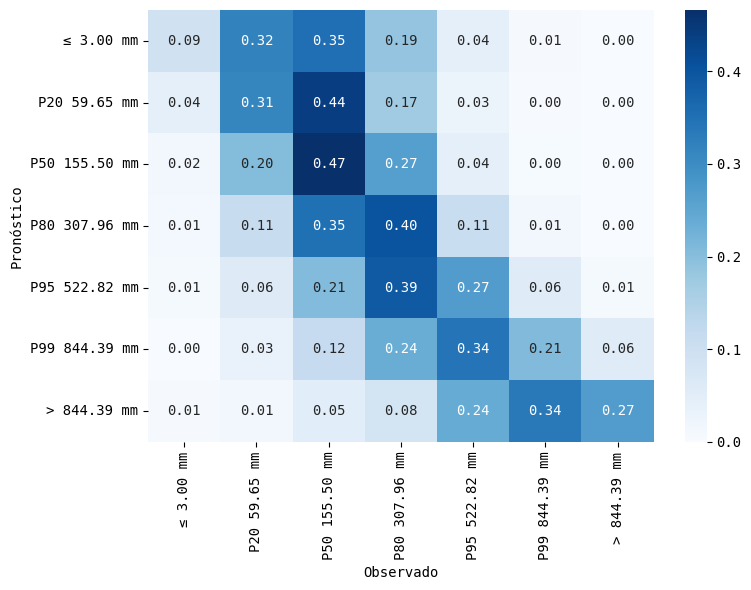

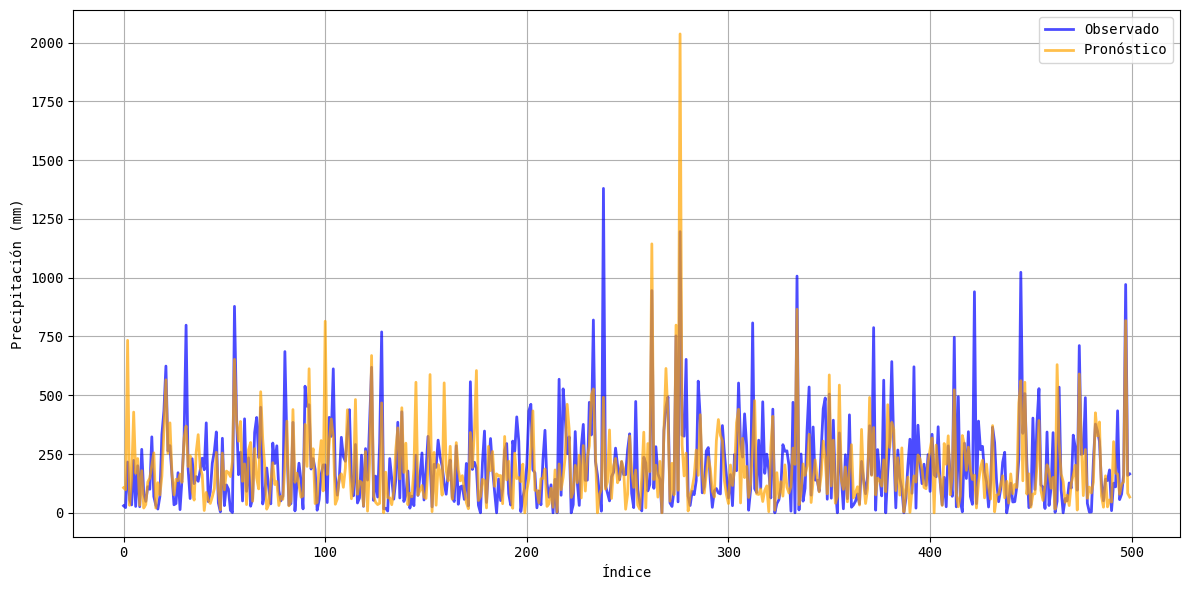

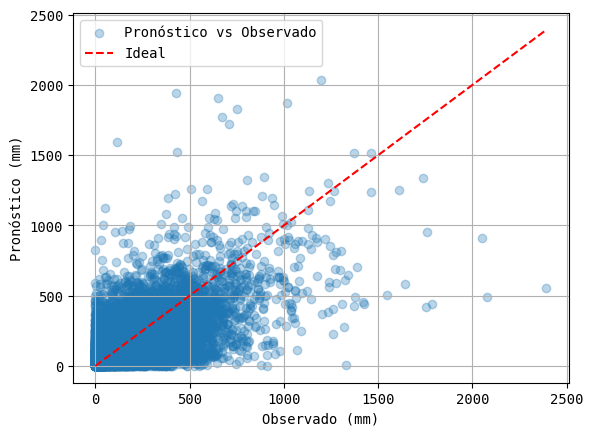

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

pred = f = np.array([forecast.mean[0] for forecast in forecasts])
o = val['Prediccion'].values * val['ValorMaximo'].values
f = pred * val['ValorMaximo'].values
f[f < 0] = 0
c = val['Climatologia'].values
m = (~np.isnan(o)) & (~np.isnan(f)) & (~np.isnan(c))
o, f, c = o[m], f[m], c[m]

print(f"Eval n={len(o)}")
rmse = np.sqrt(np.mean((f - o) ** 2))
bias = np.mean(f - o)
fa = f - c
fam = np.mean(fa)
fa2 = np.sqrt(np.mean((fa - fam) ** 2))
oa = o - c
oam = np.mean(oa)
oa2 = np.sqrt(np.mean((oa - oam) ** 2))
num = np.mean((fa - fam) * (oa - oam))
den = np.sqrt(np.mean((fa - fam) ** 2)) * np.sqrt(np.mean((oa - oam) ** 2))
ac = num / den if den != 0 else np.nan
mae = np.mean(np.abs(f - o))
nden = np.sum((o - np.mean(o)) ** 2)
nse = 1 - (np.sum((f - o) ** 2) / nden) if nden != 0 else np.nan
fb = 2 * (np.mean(f) - np.mean(o)) / (np.mean(f) + np.mean(o)) if (np.mean(f) + np.mean(o)) != 0 else np.nan

print(f"Model Lag-Llama - Metrics:")
print(f"RMSE:{rmse:.3f} MAE:{mae:.3f} Bias:{bias:.3f} FB:{fb:.3f} NSE:{nse:.3f} FA:{fa2:.3f} OA:{oa2:.3f} AC:{ac:.3f}")

# Evaluation DataFrame and confusion matrix
df_eval = pd.DataFrame({'o': o, 'f': f})
ps = df_eval['o'].quantile([0.2, 0.5, 0.8, 0.95, 0.99])
bins = [-np.inf, 3] + list(ps.values) + [np.inf]
q = ["", "P20", "P50", "P80", "P95", "P99", ""]

lbls = []
for i in range(len(bins) - 1):
    a, b = bins[i], bins[i+1]
    if np.isneginf(a):
        t = f"≤ {b:.2f} mm"
    elif np.isposinf(b):
        t = f"> {a:.2f} mm"
    else:
        t = f"{q[i]} {b:.2f} mm"
    lbls.append(t)

df_eval['o_cat'] = pd.cut(df_eval['o'], bins=bins, labels=lbls)
df_eval['f_cat'] = pd.cut(df_eval['f'], bins=bins, labels=lbls)
cm = confusion_matrix(df_eval['o_cat'], df_eval['f_cat'], labels=lbls, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=lbls, yticklabels=lbls)
plt.xlabel("Observado")
plt.ylabel("Pronóstico")
plt.tight_layout()
plt.show()

# Forecast vs observed (samples)
if len(o) > 500:
    idxs = np.random.choice(len(o), size=500, replace=False)
else:
    idxs = np.arange(len(o))
plt.figure(figsize=(12, 6))
plt.plot(o[idxs], label='Observado', color='blue', lw=2, alpha=0.7)
plt.plot(f[idxs], label='Pronóstico', color='orange', lw=2, alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Precipitación (mm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot
plt.scatter(o, f, alpha=0.3, label='Pronóstico vs Observado')
plt.plot([o.min(), o.max()], [o.min(), o.max()], 'r--', label='Ideal')
plt.xlabel('Observado (mm)')
plt.ylabel('Pronóstico (mm)')
plt.legend()
plt.grid(True)
plt.show()